# Capse.jl reloaded: using Chebyshev polynomials

In this notebook we are going to use the trained Capse.jl emulators which takes advantage of the Chebyshev polynomials decomposition. The core ides is that, rather than using a Neural Networks that outputs the $C_\ell$'s directly

$$
\theta\rightarrow \mathrm{NN}(\theta)\rightarrow C_\ell(\theta)
$$

we decompose, at a fixed cosmology, the $C_\ell$'s on the Chebyshev basis

$$
C_\ell(\theta)\approx\sum_{i=0}^N a_i(\theta)T_i
$$

where $T_i$ is the $i$-th grade Chebyshev polynomial.
In this case, the cosmological dependence is encoded in the Chebyshev expansion coefficients, which are the emulation target.

$$
\theta\rightarrow\mathrm{NN}(\theta)\rightarrow a_i(\theta)\rightarrow C_\ell(\theta)
$$

In the first part of the notebook we are showing how the Chebyshev expansions can be used to approximate the CMB $C_\ell$'s.

In the second part  we are showing how to compute some Planck chains using the emulator.

Let us start activating the static Julia environment and importing the relevant packages.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

  Activating project at `~/Desktop/papers/capse_paper/chebyshev_emulator`
  No Changes to `~/Desktop/papers/capse_paper/chebyshev_emulator/Project.toml`
  No Changes to `~/Desktop/papers/capse_paper/chebyshev_emulator/Manifest.toml`


In [2]:
using FastChebInterp
using BenchmarkTools
using LoopVectorization
using SimpleChains
using Turing
using Optim
using LinearAlgebra
using StatsPlots
using Pathfinder
using Capse
using NPZ
import MCMCChains: compute_duration
using MCMCDiagnosticTools
using StatsPlots
using MicroCanonicalHMC
using Transducers
using MCMCDiagnosticTools
using DataFrames
using PlanckLite
include("utils.jl");

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/7VQ5h/src/backends.jl:43
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]


Since we are going to focus on the Planck analysis, here we are just going to use the multipoles $\ell\in[2,2508]$.
 In this example we are using a polynomial of grade $47$.

In [3]:
min_idx = 3
max_idx = 2509

grad_cheb = 48
weights_folder = "../data/weights/weights_cheb_cosmopowerspace_10000/"
l = Float64.(npzread(weights_folder*"l.npy")[min_idx:max_idx]);

# Checking the emulator: using the validation dataset

Here we are going to show how to use the emulators and the emulation error on the validation dataset.
Here we are defining the MultiLayer Perceptron Architecture. Please: do not touch this cell!

In [4]:
mlpd = SimpleChain(
  static(6),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(identity, grad_cheb)
);

Let us load the emulators.

In [5]:
weights_TT = npzread(weights_folder*"weights_TT_lcdm.npy")
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TT)
CℓTT_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TT, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTT_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [6]:
weights_EE = npzread(weights_folder*"weights_EE_lcdm.npy")
trained_emu_EE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_EE)
CℓEE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_EE, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓEE_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [7]:
weights_TE = npzread(weights_folder*"weights_TE_lcdm.npy")
trained_emu_TE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TE)
CℓTE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TE, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTE_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [8]:
weights_PP = npzread(weights_folder*"weights_PP_lcdm.npy")
trained_emu_PP = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_PP)
CℓPP_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_PP, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓPP_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

The first thing to do is to evalute the PolyGrid: the polynomials on the $\ell$ grid used in the training.
After the evaluation, the result is stored and doesn't need to be computed again.

In [9]:
Capse.eval_polygrid!(CℓEE_emu)
Capse.eval_polygrid!(CℓTT_emu)
Capse.eval_polygrid!(CℓTE_emu)
Capse.eval_polygrid!(CℓPP_emu)

Let us now benchmark the $C_\ell$'s computation

In [10]:
input_test = rand(6)
@benchmark Capse.get_Cℓ($input_test, $CℓTE_emu)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   9.939 μs …  2.773 ms  ┊ GC (min … max): 0.00% … 98.29%
 Time  (median):     13.165 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.294 μs ± 38.357 μs  ┊ GC (mean ± σ):  3.71% ±  1.39%

        ▃▇█▇▅▂             ▁▂▁▁                                
  ▁▁▁▂▄▆███████▇▆▅▄▃▃▃▃▄▄▅▇████▇▇▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁ ▃
  9.94 μs         Histogram: frequency by time        20.6 μs <

 Memory estimate: 21.45 KiB, allocs estimate: 11.

And also the Chebyshev coefficients emulation

In [11]:
@benchmark Capse.get_chebcoefs($input_test, $CℓTE_emu)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  3.054 μs … 751.489 μs  ┊ GC (min … max): 0.00% … 98.97%
 Time  (median):     3.678 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.756 μs ±   7.493 μs  ┊ GC (mean ± σ):  1.98% ±  0.99%

        █       ▂ ▂▃                                           
  ▁▂▃▃▃▇█▆▄▂▃▄▄▄██████▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  3.05 μs         Histogram: frequency by time        5.38 μs <

 Memory estimate: 1.78 KiB, allocs estimate: 9.

Here we want to emphasize an important point:

- emulating the Chebyshev coefficients requires around $4\,\mu s$
- emulating the Chebyshev coefficients $\textit{and}$  computing the $C_\ell$'s takes $15\,\mu s$

This simple observation can suggest us something: if we are able to write the likelihood in such a way that we do NOT compute the $C_\ell$'s we can improve the overall computational performance.

# Chains

Now we are showing how to compute some chains using the trained emulators. We are using the MOPED approach: let us load the compression vectors.

In [12]:
ln10As_vec = npzread("ln10_As_compression_vector_2018_TTTEEE_high_ell.npy")
ns_vec = npzread("ns_compression_vector_2018_TTTEEE_high_ell.npy")
h_vec = npzread("h_compression_vector_2018_TTTEEE_high_ell.npy")
ωb_vec = npzread("omega_b_compression_vector_2018_TTTEEE_high_ell.npy")
ωc_vec = npzread("omega_cdm_compression_vector_2018_TTTEEE_high_ell.npy")
τ_vec = npzread("tau_compression_vector_2018_TTTEEE_high_ell.npy");

Let us write a couple of utility functions that can compute the $C_\ell$'s for the Planck likelihood

In [13]:
lsTT = 2:2508
lsTE = 2:1996
facTT=lsTT.*(lsTT.+1)./(2*π)
facTE=lsTE.*(lsTE.+1)./(2*π)

function call_emu_planck(θ, Emu_TT, Emu_TE, Emu_EE, facTT, facTE)
    return vcat(Capse.get_Cℓ(θ, Emu_TT)[1:2507]./facTT, Capse.get_Cℓ(θ, Emu_TE)[1:1995]./facTE, Capse.get_Cℓ(θ, Emu_EE)[1:1995]./facTE)
end

theory_planck(θ) = call_emu_planck(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu, facTT, facTE)

theory_planck (generic function with 1 method)

Let us benchmark the theory function

In [14]:
x = rand(6)
@benchmark theory_planck($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  45.224 μs …   3.755 ms  ┊ GC (min … max): 0.00% … 93.31%
 Time  (median):     63.727 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   72.705 μs ± 129.491 μs  ┊ GC (mean ± σ):  7.40% ±  4.15%

    ▁█      ██▁                                                 
  ▁▁███▅▄▃▃▅███▆▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁ ▂
  45.2 μs         Histogram: frequency by time          147 μs <

 Memory estimate: 217.75 KiB, allocs estimate: 49.

Let us now write the Planck likelihood using `Turing.jl`, a Probabilistic Programming Language written in Julia

In [15]:
@model function CMB_planck(ln10As_vec, ns_vec, h_vec, ωb_vec, ωc_vec, τ_vec)
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.0506, 0.0086)
    yₚ     ~ Normal(1.0, 0.0025)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    pred = theory_planck(θ)./(yₚ^2)
    
    3.922171844089508 ~ Normal(dot(pred, ln10As_vec), 1)
    -0.3373841460189034 ~ Normal(dot(pred, ns_vec), 1)
    -92.47399908326949 ~ Normal(dot(pred, h_vec), 1)
    -239.19578126925958 ~ Normal(dot(pred, ωb_vec), 1)
    -440.73988677167665 ~ Normal(dot(pred, ωc_vec), 1)
    -395.3913922531443 ~ Normal(dot(pred, τ_vec), 1)
    
end

CMB_model_planck = CMB_planck(ln10As_vec, ns_vec, h_vec, ωb_vec, ωc_vec, τ_vec)

DynamicPPL.Model{typeof(CMB_planck), (:ln10As_vec, :ns_vec, :h_vec, :ωb_vec, :ωc_vec, :τ_vec), (), (), NTuple{6, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(CMB_planck, (ln10As_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.4049790023128523, -0.40538663090098803, -0.40579446453368523, -0.4062025032109438, -0.40661074693276383, -0.40701919569914535, -0.4074278495100882, -0.4078367083655926, -0.4082457722656584, -0.4086550412102856], ns_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.607191676977549, 1.608809383748538, 1.6104279042553273, 1.6120472384979168, 1.6136673864763067, 1.615288348190497, 1.6169101236404873, 1.618532712826278, 1.6201561157478692, 1.6217803324052604], h_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -2.1210417306435128, -2.1231766493457207, -2.1253126419506962, -2.1274497084584394, -2.1295878488689506, -2.1317270631822294, -2.1338673513982758, -2.1360087135170898, -2.138151149538672, -2.140294659463021], ωb_vec 

Using `Turing.jl` together with `Optim.jl`, we can compute the maximum a posteriori pretty easily

In [16]:
bestfit_Planck = optimize(CMB_model_planck, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

ModeResult with maximized lp of 10.63
[0.30521169786255337, 0.9633921850431266, 0.671324413846162, 0.22342088529826365, 0.12064521895688657, 0.05723431210901401, 1.0005303785418371]

In [17]:
@benchmark optimize(CMB_model_planck, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  145.564 ms … 401.382 ms  ┊ GC (min … max): 6.50% … 4.81%
 Time  (median):     184.368 ms               ┊ GC (median):    5.27%
 Time  (mean ± σ):   206.587 ms ±  61.590 ms  ┊ GC (mean ± σ):  4.93% ± 0.68%

   █ ▃  ▃  ▃                        ▃                            
  ▇█▁█▇▇█▇▇█▇▇▁▁▇▁▇▁▁▁▁▁▁▇▇▁▁▇▁▁▁▁▁▁█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  146 ms           Histogram: frequency by time          401 ms <

 Memory estimate: 229.57 MiB, allocs estimate: 17882.

We can also use `Pathfinder.jl` to compute some points to initialize our chains

In [18]:
result_multi = multipathfinder(CMB_model_planck, 5000; nruns=6, executor = Transducers.PreferParallel())
@time multipathfinder(CMB_model_planck, 5000; nruns=6, executor = Transducers.PreferParallel())

┌ Warning: 1 (0.3%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (0.7%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (0.8%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.9%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

  6.260495 seconds (3.83 M allocations: 15.249 GiB, 9.05% gc time)


Multi-path Pathfinder result
  runs: 6
  draws: 5000
  Pareto shape diagnostic: 0.5 (ok)

Pretty nice! As expected, Pathfinder delivers an approximation of the posterior in around 6 seconds!
Furthermore,  we can use `Pathfinder.jl` draws to initialize our MonteCarlo Markov Chains

In [19]:
nsteps = 5000
nadapts = 500
nchains = 6

init_params = collect.(eachrow(result_multi.draws_transformed.value[1:nchains, :, 1]));

In [20]:
chains_planck_std_NUTS = sample(CMB_model_planck, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params = init_params)

┌ Info: Found initial step size
└   ϵ = 0.0007568359375
┌ Info: Found initial step size
└   ϵ = 0.0006835937500000001
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:01:57


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 790.98 seconds
Compute duration  = 4540.25 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3052    0.0017     0.0000    0.0000   11095.4246    1.0003   ⋯
          ns    0.9634    0.0044     0.0000    0.0000   10561.0876    1.0002   ⋯
          h0    0.6714    0.0061     0.0000    0.0001    8224.0864    1.0002   ⋯
          ωb    0.2234    0.0015     0.0000    0.0000   10980.9666    1.0000   ⋯
          ωc    0.1206    0.0014     0.0

The parallelization is pretty effective! We can compute 6 chains in parallel with no particular effort, performing a PlanckLite analysis in a few minutes. However, we can still do better, as we will show in the next section.

# Chains with Cheb coefs

The core idea is pretty simple, as always. If we can write the logl (or part of it) as a linear operator $L$ acting on the $C_\ell$, we can store the action of $L$ on the basis functions $T_i$ and multiply them with the emulated coefficients $a_i(\theta)$, that encodes the dependence form the cosmological parameters $\theta$.

In order to reach this goal, we need to:

- compute and store the logl action on the Chebyshev polynomials. This need to be done only once (and will hence save a lot of computational resources)
- multiply the result of the previous calculation with the emulated coefficients $a_i(\theta)$

Let us start writing a function that MOPED-compresses the Chebyshev polynomials

In [21]:
function compute_compressed_matrix(PolyGrid, ℓgrid, compression_vector)
    compressed_matrix = zeros(3,48)#48 degree cheb
    for i in 1:48
        compressed_matrix[1,i] = dot(compression_vector[1:2507], PolyGrid[:,i]./(ℓgrid.*(ℓgrid.+1)./(2*π)))
        compressed_matrix[2,i] = dot(compression_vector[2508:2508+1994], PolyGrid[1:1995,i]./(ℓgrid[1:1995].*(ℓgrid[1:1995].+1)./(2*π)))
        compressed_matrix[3,i] = dot(compression_vector[2508+1995:end], PolyGrid[1:1995,i]./(ℓgrid[1:1995].*(ℓgrid[1:1995].+1)./(2*π)))
    end
    return compressed_matrix
end

compute_compressed_matrix (generic function with 1 method)

In [22]:
ln10As_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ln10As_vec)
ns_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ns_vec)
h_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, h_vec)
ωb_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ωb_vec)
ωc_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l,ωc_vec)
τ_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, τ_vec);

Now let's write a function that computes the coefficients, given the input parameters

In [23]:
function call_emu_planck_coeffs(θ, Emu_TT, Emu_TE, Emu_EE)
    return hcat(Capse.get_chebcoefs(θ, Emu_TT), Capse.get_chebcoefs(θ, Emu_TE), Capse.get_chebcoefs(θ, Emu_EE))
end

theory_planck_coeffs(θ) = call_emu_planck_coeffs(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu)

theory_planck_coeffs (generic function with 1 method)

Let's benchmark it

In [24]:
@benchmark theory_planck_coeffs($input_test)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.074 μs … 61.190 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.688 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.993 μs ±  1.724 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

              █▃▁   ▃                                          
  ▁▂▂▂▂▃▇▇▆▄▅▇███▇▆███▆▅▄▄▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  10.1 μs         Histogram: frequency by time        20.6 μs <

 Memory estimate: 6.59 KiB, allocs estimate: 29.

Around 5 times faster than the previous `theory_planck` function! 
Now let's write a function that, given the compressed matrix, gives back the full compressed statistics for each parameter.

In [25]:
function compressed_statistics(compressed_matrix, coeff_matrix)
    result = 0
    @turbo for i in 1:3
        for j in 1:48
            result += compressed_matrix[i,j]*coeff_matrix[j,i]
        end
    end
    return result
end

compressed_statistics (generic function with 1 method)

One might wonder: is this approach precise? Are we trading precision with speed? Let's compare the compressed statistic computed with old and the new approach.

In [26]:
coeffs = theory_planck_coeffs(input_test)
compressed_statistics(τ_matrix, coeffs)

-48.48568463670965

In [27]:
testCℓ = theory_planck(input_test)
dot(testCℓ, τ_vec)

-48.48568463670964

They are the same up to machine precision!

In [28]:
@benchmark compressed_statistics($τ_matrix, $coeffs)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  18.741 ns … 115.085 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     23.981 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.278 ns ±   1.640 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▃      ▂  ▁▁  █▁  ▇▁   ▄                     ▂
  ▇▁▁▁▁▁▁▁▃▁▁▁▁█▁▁█▅▄█▇▁▅█▅▄██▃▃██▆▆██▇▅▆█▆▅▅▆▅▅▄▅▇▅▄▄▅▆▅▅▃▄▅▇ █
  18.7 ns       Histogram: log(frequency) by time      28.9 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

And it is so fast that doesn't add any appreciable slowdown to the code! Let us now write the likelihood in this new approach.

In [29]:
@model function CMB_planck_cheb(ln10As_matrix, ns_matrix, h_matrix, ωb_matrix, ωc_matrix, τ_matrix)
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.0506, 0.0086)
    yₚ     ~ Normal(1.0, 0.0025)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    pred = theory_planck_coeffs(θ)./(yₚ^2)
    
    3.922171844089508    ~ Normal(compressed_statistics(ln10As_matrix, pred), 1)
    -0.3373841460189034 ~ Normal(compressed_statistics(ns_matrix, pred), 1)
    -92.47399908326949   ~ Normal(compressed_statistics(h_matrix, pred), 1)
    -239.19578126925958  ~ Normal(compressed_statistics(ωb_matrix, pred), 1)
    -440.73988677167665   ~ Normal(compressed_statistics(ωc_matrix, pred), 1)
    -395.3913922531443   ~ Normal(compressed_statistics(τ_matrix, pred), 1)
    
end

CMB_model_planck_cheb = CMB_planck_cheb(ln10As_matrix, ns_matrix, h_matrix, ωb_matrix, ωc_matrix, τ_matrix)

DynamicPPL.Model{typeof(CMB_planck_cheb), (:ln10As_matrix, :ns_matrix, :h_matrix, :ωb_matrix, :ωc_matrix, :τ_matrix), (), (), NTuple{6, Matrix{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(CMB_planck_cheb, (ln10As_matrix = [0.06758252389046465 -0.038807738367276835 … -0.006535681525605787 -0.03678605116317916; 0.5346232630023648 -0.16684666855032587 … -0.020926852713021717 0.0372778871685449; 4.6829747608843855 -3.8458799451164705 … 0.3643049565350073 -0.329772031812445], ns_matrix = [0.1149983254914529 -0.014036197944598943 … -0.0027019296349469744 0.0029962621580787146; 1.1892800875057892 -0.4447163861032105 … -0.049664479377216596 0.017078326748444818; -24.23866142804499 22.325226581710734 … 0.043169658162025205 -0.13751953648528767], h_matrix = [-0.06963758920311944 0.026597651841518227 … 0.020838566626061632 0.003363220325725364; 0.06791680263165868 -0.024592224084992384 … -0.011956147001187988 0.003671381088973146; 3.033364276062211 -2.410877731431048 … 0.09074810380717198 -0.10

In [30]:
bestfit_Planck = optimize(CMB_model_planck_cheb, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

┌ Warning: #= In[25]:3 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main ~/.julia/packages/LoopVectorization/91gMc/src/condense_loopset.jl:1148


ModeResult with maximized lp of 10.63
[0.3052116978625624, 0.9633921850432814, 0.6713244138462395, 0.22342088529826984, 0.12064521895685582, 0.05723431210913533, 1.000530378541817]

The result is the same as before! What about speed-side?

In [31]:
 @benchmark optimize(CMB_model_planck_cheb, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

┌ Warning: Optimization did not converge! You may need to correct your model or adjust the Optim parameters.
└ @ Turing ~/.julia/packages/Turing/cplDJ/src/modes/OptimInterface.jl:243


BenchmarkTools.Trial: 522 samples with 1 evaluation.
 Range (min … max):  4.654 ms … 32.522 ms  ┊ GC (min … max): 0.00% … 27.99%
 Time  (median):     8.166 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.567 ms ±  4.095 ms  ┊ GC (mean ± σ):  8.27% ± 13.62%

    ▁▂▁▅▆▇█▆▆ ▁▂                                              
  ▃▃████████████▇▅▇▄▅▆▄▅▃▄▄▃▃▄▃▃▃▃▃▃▄▃▃▂▄▂▃▂▂▃▃▂▂▂▁▂▁▃▂▁▁▂▁▃ ▄
  4.65 ms        Histogram: frequency by time        24.7 ms <

 Memory estimate: 4.88 MiB, allocs estimate: 12074.

We have reduced the minimization time by a factor of ~ $10$.

Let's check what happens with `Pathfinder.jl`

In [32]:
multipathfinder(CMB_model_planck_cheb, 5000; nruns=8, executor = Transducers.PreferParallel())
@time result_multi_cheb = multipathfinder(CMB_model_planck_cheb, 5000; nruns=8, executor = Transducers.PreferParallel())

┌ Warning: 2 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (0.9%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.3%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

  0.709176 seconds (3.92 M allocations: 941.570 MiB, 15.31% gc time)


Multi-path Pathfinder result
  runs: 8
  draws: 5000
  Pareto shape diagnostic: 0.52 (ok)

Speed-up of a factor of $8$! Now `Pathfinder.jl` lasted only for $0.5\,s$.

Let's now compute some chains!

In [33]:
init_params = collect.(eachrow(result_multi_cheb.draws_transformed.value[1:nchains, :, 1]));

In [34]:
chains_planck_cheb_NUTS = sample(CMB_model_planck_cheb, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params = init_params)

┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.000390625
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:00:24


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 54.23 seconds
Compute duration  = 228.4 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3052    0.0017     0.0000    0.0000   11229.6510    1.0002   ⋯
          ns    0.9635    0.0044     0.0000    0.0000    9989.6527    1.0004   ⋯
          h0    0.6714    0.0061     0.0000    0.0001    8151.5822    1.0006   ⋯
          ωb    0.2234    0.0015     0.0000    0.0000   11169.8709    1.0004   ⋯
          ωc    0.1206    0.0014     0.0000

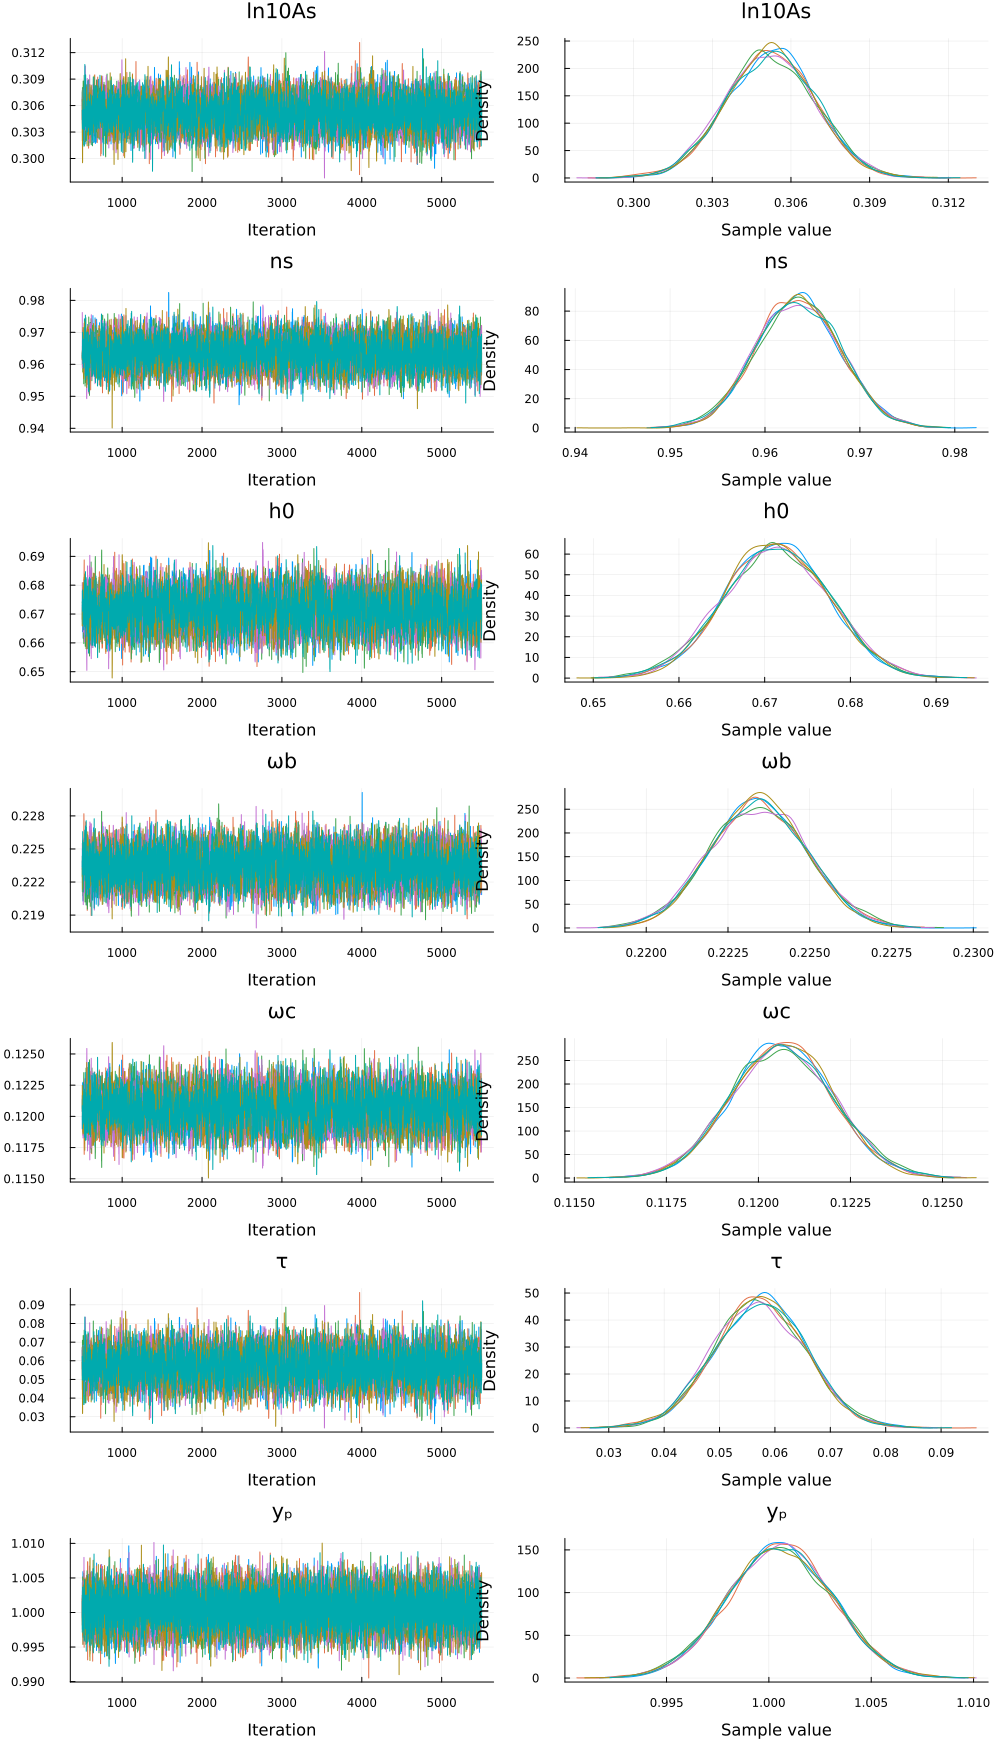

In [35]:
p = StatsPlots.plot(chains_planck_cheb_NUTS)
StatsPlots.savefig("traceplots_Planck.png")
p

In [36]:
CPU_s_Planck_NUTS = compute_duration(chains_planck_cheb_NUTS)
Planck_NUTS_ESS = mean(MCMCDiagnosticTools.ess_rhat(chains_planck_cheb_NUTS)[[:ln10As, :ns, :h0, :ωb,:ωc, :τ, :yₚ],:ess])
Planck_NUTS_ESS_s = Planck_NUTS_ESS/CPU_s_Planck_NUTS

60.65377353329167

In [37]:
npzwrite("chains_Planck_cheb_NUTS.npy", combine_chains(chains_planck_cheb_NUTS))

# MCHMC stuff

In [38]:
d = 7
target = TuringTarget(CMB_model_planck_cheb)
nadapts = 20_000
nsteps = 200000

spl = MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d),# sigma=ones(d),  #try higher init_eps
            adaptive=true)
start_mchmc = time()
@time planck_mchmc = Sample(spl, target, nsteps;
                    progress=true,
                    dialog=true, file_name="chain_1",
                    initial_x=bestfit_Planck.values.array)
end_mchmc = time()
end_mchmc - start_mchmc

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  18%|██████▍                            |  ETA: 0:00:03

Burn in step: 4000
eps --->0.0009021358003531806


MCHMC (tuning):  37%|████████████▊                      |  ETA: 0:00:02

Burn in step: 8000
eps --->0.02257269936182347


MCHMC (tuning):  58%|████████████████████▎              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.030315057347492257


MCHMC (tuning):  79%|███████████████████████████▊       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.03044155432097816


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.03179806635521243


[ Info: eps: 0.03179806635521243
[ Info: L: 2.6457513110645907
[ Info: nu: 0.05895312670194497
[ Info: sigma: [0.24643307900554953, 0.7550161014707356, 0.4633464417731292, 0.21495297214151407, 0.14768693556962847, 0.019185389068767014, 0.004775244323435974]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14

 21.792301 seconds (73.05 M allocations: 30.454 GiB, 15.36% gc time, 15.97% compilation time: <1% of which was recompilation)


21.81182289123535

In [39]:
n_parallel_mchmc = 8
chains = Vector{Any}(undef, n_parallel_mchmc)
vec_ess = zeros(n_parallel_mchmc)

@time for i in 1:n_parallel_mchmc
    chains[i] = Sample(MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d), adaptive=true), target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_Planck.values.array)
    vec_ess[i] = mean(Summarize(chains[i])[1][1:7])
end

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████▏                           |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0007120280079110841


MCHMC (tuning):  39%|█████████████▌                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.016088585319767184


MCHMC (tuning):  59%|████████████████████▌              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.032782608805480645


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.020530600368326875


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.029752459327808265


[ Info: eps: 0.029752459327808265
[ Info: L: 2.6457513110645907
[ Info: nu: 0.057003219002543334
[ Info: sigma: [0.054446160045956093, 0.32421741143240074, 0.9314053957430665, 0.35722036321740797, 0.33491631407204386, 0.009683264275317774, 0.002311225104565213]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  15%|█████▏                             |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0013533234213866103


MCHMC (tuning):  40%|█████████████▉                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.01664359821238638


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.024590380190165403


MCHMC (tuning):  79%|███████████████████████████▋       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.026804188926383973


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.028707694806498874


[ Info: eps: 0.028707694806498874
[ Info: L: 2.6457513110645907
[ Info: nu: 0.05598233937429872
[ Info: sigma: [0.2618761027479764, 0.5989260570153847, 0.5488701629545955, 0.20567632245265824, 0.35629611241486203, 0.021076732384384123, 0.004863900534274561]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|██████▉                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0010072622382865692


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.005128914641632116


MCHMC (tuning):  59%|████████████████████▌              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.011119523069569742


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.011351110528163883


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.013239780102630435


[ Info: eps: 0.013239780102630435
[ Info: L: 2.6457513110645907
[ Info: nu: 0.03790699876193684
[ Info: sigma: [0.9716297166744498, 0.4115858376727528, 0.7205607550332802, 0.22625075898904204, 0.3628594830231211, 0.024561163860258205, 0.039431024844305856]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|██████▉                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0022931380134171802


MCHMC (tuning):  38%|█████████████▎                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.028646358046736518


MCHMC (tuning):  58%|████████████████████▏              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.029513671315801345


MCHMC (tuning):  79%|███████████████████████████▌       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.024977696729273878


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.031235943575523208


[ Info: eps: 0.031235943575523208
[ Info: L: 2.6457513110645907
[ Info: nu: 0.058423488329224865
[ Info: sigma: [0.17982647187170833, 0.2810472313784795, 0.9644828770200494, 1.3323146156663013, 0.2057011399396616, 0.015510605148075491, 0.011018772521557788]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.001403502534039715


MCHMC (tuning):  38%|█████████████▎                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.030468042974400828


MCHMC (tuning):  58%|████████████████████▍              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.04422830063919828


MCHMC (tuning):  79%|███████████████████████████▊       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.04420085473450684


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.07399864563219072


[ Info: eps: 0.07399864563219072
[ Info: L: 2.6457513110645907
[ Info: nu: 0.09065776832200206
[ Info: sigma: [0.0636869083688975, 0.5743931140084643, 0.4320334740635067, 0.3928861633854863, 0.16674337854827176, 0.010393814725986142, 0.0024324924916981883]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|██████▉                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0010852355146767575


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.039194312789016215


MCHMC (tuning):  58%|████████████████████▎              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.04782023701587222


MCHMC (tuning):  79%|███████████████████████████▋       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.07042608248134502


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.07667116172566518


[ Info: eps: 0.07667116172566518
[ Info: L: 2.6457513110645907
[ Info: nu: 0.09232739582062935
[ Info: sigma: [0.08267844649178299, 0.2930820561916494, 0.33894394220758517, 0.37308576775682545, 0.12341108876341732, 0.00916226257909905, 0.002572486927391673]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▋                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0012444503800879859


MCHMC (tuning):  38%|█████████████▏                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.029326181362293955


MCHMC (tuning):  58%|████████████████████▎              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.022039444940539697


MCHMC (tuning):  79%|███████████████████████████▋       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.0416315219052355


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.03366088024597534


[ Info: eps: 0.03366088024597534
[ Info: L: 2.6457513110645907
[ Info: nu: 0.06067681015845268
[ Info: sigma: [0.1949538721282746, 0.24813443907614877, 0.5426411288398142, 0.49579821398207113, 0.3130196373295155, 0.012931177444705571, 0.0034405413543538567]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  15%|█████▎                             |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0010127839472413333


MCHMC (tuning):  39%|█████████████▋                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.025008015823606223


MCHMC (tuning):  59%|████████████████████▌              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.03559315315132164


MCHMC (tuning):  79%|███████████████████████████▊       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.03117520809087349


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.03589529993155204


[ Info: eps: 0.03589529993155204
[ Info: L: 2.6457513110645907
[ Info: nu: 0.06268490780521725
[ Info: sigma: [0.1865269149410132, 0.11252947405975292, 0.23379560076599443, 0.23805137777317717, 0.11918418040104299, 0.019119387320080106, 0.009304248336856747]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13

157.830363 seconds (536.38 M allocations: 288.407 GiB, 18.16% gc time)


In [40]:
_chains = zeros(200000, 2, 7)
_chains[:,1,:] = mapreduce(permutedims, vcat, chains[1])[:,1:7]
_chains[:,2,:] = mapreduce(permutedims, vcat, chains[2])[:,1:7];

In [42]:
x = [mapreduce(permutedims, vcat, chains[i]) for i in 1:n_parallel_mchmc];
chains_planck_mchmc_multi = zeros(nsteps*n_parallel_mchmc, 7)
for i in 1:7
    chains_planck_mchmc_multi[:,i] = extract_single(x, i, n_parallel_mchmc)
end

In [43]:
vec_ess

8-element Vector{Float64}:
 2220.5867291106324
 3026.4044801569703
 2088.26992344776
 4641.279700156166
 4190.678794833947
 4096.147676175799
 3037.9967660296397
 2704.631916300747

In [44]:
planck_mchmc_parallel_ess_s = sum(vec_ess)/(n_parallel_mchmc*(end_mchmc - start_mchmc))

149.0361220374069

In [45]:
_planck_mchmc = mapreduce(permutedims, vcat, planck_mchmc)
E = _planck_mchmc[:, end-1]
std(E).^2/d

0.0010251432044958524

In [46]:
npzwrite("chains_Planck_cheb_MOPED_MCHMC.npy", _planck_mchmc)
npzwrite("chains_Planck_cheb_MOPED_MCHMC_multi.npy", chains_planck_mchmc_multi)